In [130]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
import prepare

In [2]:
#pd.set_option('display.max_rows', 111753)

# Data Acquisition

In [98]:
df = pd.read_csv('Austin_Animal_Center_Outcomes.csv')
df.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A720371,Moose,02/13/2016 05:59:00 PM,02/13/2016 05:59:00 PM,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
1,A674754,NaN,03/18/2014 11:47:00 AM,03/18/2014 11:47:00 AM,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby
2,A689724,*Donatello,10/18/2014 06:52:00 PM,10/18/2014 06:52:00 PM,08/01/2014,Adoption,NaN,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black
3,A680969,*Zeus,08/05/2014 04:59:00 PM,08/05/2014 04:59:00 PM,06/03/2014,Adoption,NaN,Cat,Neutered Male,2 months,Domestic Shorthair Mix,White/Orange Tabby
4,A684617,NaN,07/27/2014 09:00:00 AM,07/27/2014 09:00:00 AM,07/26/2012,Transfer,SCRP,Cat,Intact Female,2 years,Domestic Shorthair Mix,Black


In [99]:
# peek at the df dimension
df.shape

(111753, 12)

In [104]:
# list missing value by col
# need to decide what to do
prepare.report_col_with_null_df(df)

,0,1,2,3,4
0,Name,Outcome Type,Outcome Subtype,Sex upon Outcome,Age upon Outcome
0,35244,8,60878,4,36


In [109]:
pd.DataFrame(df.apply(lambda x: round(sum(x.isnull()/len(df)),2))).T

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,0.0,0.32,0.0,0.0,0.0,0.0,0.54,0.0,0.0,0.0,0.0,0.0


# Conludsion for Initial observation
- Overall, seems like this dataset is relatively complete
- Name & Outcome Subtypes, missin a large portion of data
>
- Initial run, might just completely ignore name and outcome subtype, but I have an hypothesis that name might have a bit of inflence on outcome.  For example if a more human like name (Jackie?) versus something not so human (Spotty?), could it be a factor for adoption outcome?
- or if there's a difference between having name or no name?
>
- Before jumping to the conclusion and completely remove the column - Outcome Subtype, want to double check how does it differ from Outcome Type.

In [100]:
# notes:

# all columns are object types
# MonthYear seemed to be same with DateTime, may drop the col
# animal type maybe just parse dog and cat into 2 df and drop the other species for this analysis

# Derive age from DOB may be more useful?
# age upon outcome might be used instead of calculating age from DOB
# DOB/ age, age upon outcome, sex, breed, color might be the most valuable for prediction
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111753 entries, 0 to 111752
Data columns (total 12 columns):
Animal ID           111753 non-null object
Name                76509 non-null object
DateTime            111753 non-null object
MonthYear           111753 non-null object
Date of Birth       111753 non-null object
Outcome Type        111745 non-null object
Outcome Subtype     50875 non-null object
Animal Type         111753 non-null object
Sex upon Outcome    111749 non-null object
Age upon Outcome    111717 non-null object
Breed               111753 non-null object
Color               111753 non-null object
dtypes: object(12)
memory usage: 10.2+ MB


In [123]:
# double check if DateTime & MonthYear columns are identical
# Yes, so we can safely remove MonthYear
(df["DateTime"] == df["MonthYear"]).mean()

1.0

In [101]:
# compare information in the 2 columns, outcome type and outcome subtype 
# seems like for the first iteration, we can safely remove outcome subtype
# for one it does miss a good portion of data
# for second, the information doesn't seem particularly helpful

print(f"""
What does 'Outcome Type' column tell us?

{df['Outcome Type'].unique()}
-------------------------------------------
      
How does 'Outcome Subtype' Differ?

{df['Outcome Subtype'].unique()}
""")


What does 'Outcome Type' column tell us?

['Adoption' 'Transfer' 'Return to Owner' 'Euthanasia' 'Rto-Adopt' 'Died'
 'Disposal' 'Missing' 'Relocate' nan]
-------------------------------------------
      
How does 'Outcome Subtype' Differ?

[nan 'Partner' 'SCRP' 'Underage' 'Suffering' 'Rabies Risk' 'Offsite' 'Snr'
 'Foster' 'Aggressive' 'Medical' 'In Kennel' 'Enroute' 'In Foster'
 'Behavior' 'Possible Theft' 'At Vet' 'In Surgery' 'Field'
 'Court/Investigation' 'Barn' 'Prc' 'Customer S']



**Decision for handling missing data**
- Name: keep for exploration, does name cause any difference?

- Outcome Type: **dropna** we can afford dropping the 8 missing value

- Outcome Subtype: seems like we can temperarily just **drop column**

- Sex upon outcome: **dropna** we can afford dropping the 4 missing value
> **feature engineer** extract only sex, and drop the other parts in the col

- Age upon outcome: **dropna feature engineer** convert into year/int

In [126]:
# this subsetting contain all info in 'Name' 
# so we could explore the relationship between name and adoption within same species

cat = df[df['Animal Type'] == 'Cat']
dog = df[df['Animal Type'] == 'Dog']

In [145]:
cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42230 entries, 1 to 111752
Data columns (total 12 columns):
Animal ID           42230 non-null object
Name                23222 non-null object
DateTime            42230 non-null object
MonthYear           42230 non-null object
Date of Birth       42230 non-null object
Outcome Type        42230 non-null object
Outcome Subtype     26290 non-null object
Animal Type         42230 non-null object
Sex upon Outcome    42230 non-null object
Age upon Outcome    42227 non-null object
Breed               42230 non-null object
Color               42230 non-null object
dtypes: object(12)
memory usage: 4.2+ MB


In [127]:
# drop unnecessary columns or columns with too many missing value

df.drop(columns = ['Outcome Subtype', 'Name', 'Animal ID', 'MonthYear', 'Date of Birth'], inplace = True)

In [128]:
# drop the missing values
df.dropna(inplace = True)

In [129]:
# rename the columns for easier typing

df.rename(columns = ({'DateTime':'date_time', 
                      'Outcome Type':'outcome', 
                      'Animal Type': 'species', 
                      'Sex upon Outcome': 'sex',
                      'Age upon Outcome': 'age_destiny', 
                      'Breed': 'breed', 
                      'Color': 'color'}), inplace = True)

**Begin feature engineering**

1. Sex upon Outcome	
> extract only sex, and drop the other parts in the col

2. Age upon Outcome
> convert into year/int

In [33]:
# take a look at the different data formats
# easy enough, just mask the raws containing 'Male' or 'Female' 
# reassign as only the sex perspectively to the original col
df.sex.unique()

array(['Neutered Male', 'Intact Male', 'Intact Female', 'Spayed Female',
       'Unknown'], dtype=object)

In [156]:
df.outcome.unique()

array(['Adoption', 'Transfer', 'Return to Owner', 'Euthanasia',
       'Rto-Adopt', 'Died', 'Disposal', 'Missing', 'Relocate'],
      dtype=object)

<Figure size 1440x360 with 0 Axes>

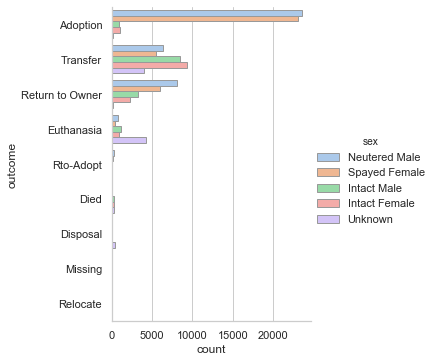

In [163]:
# explore if there's a difference between neutered/ intact
plt.figure(figsize=(20,5))
sns.catplot(y="outcome", hue="sex", kind="count",
            palette="pastel", edgecolor=".6",
            data=df,
            order = ['Adoption', 'Transfer', 'Return to Owner', 'Euthanasia','Rto-Adopt', 'Died', 'Disposal', 'Missing', 'Relocate'],
            hue_order = ['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female','Unknown'])

<Figure size 1440x720 with 0 Axes>

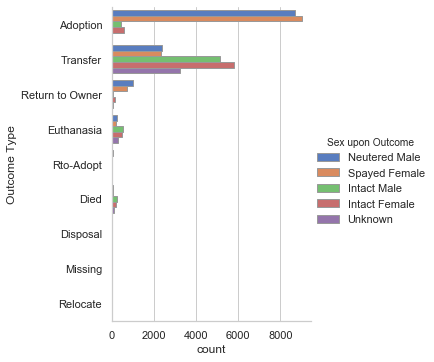

In [166]:
# cat-only: explore if there's a difference between neutered/ spayed & intact 

# Adopted ones, neutered/spayed definitely much more than intact
# higher % of intact cats get transfered
# WHAT DOES TRANSFER REALLY MEANS???

# Look at underlying info: intact vs non-intact

# compared with dogs, there's is a higher proportion of cats get transfered
# dogs shows higher return to owner rate
plt.figure(figsize=(20,10))
sns.catplot(y="Outcome Type", hue="Sex upon Outcome", kind="count",
            palette="muted", edgecolor=".6",
            data=cat,
            order = ['Adoption', 'Transfer', 'Return to Owner', 'Euthanasia','Rto-Adopt', 'Died', 'Disposal', 'Missing', 'Relocate'],
            hue_order = ['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female','Unknown'])

<Figure size 1440x720 with 0 Axes>

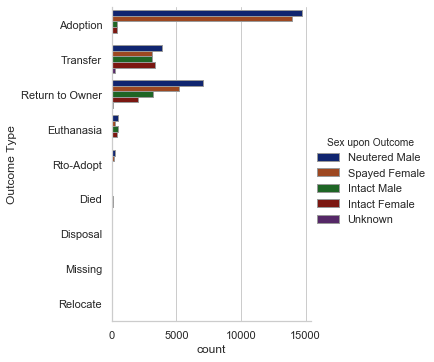

In [234]:
# dog-only: explore if there's a difference between neutered/ spayed & intact
plt.figure(figsize=(20,10))
sns.catplot(y="Outcome Type", hue="Sex upon Outcome", kind="count",
            palette="dark", edgecolor=".6",
            data=dog,
            order = ['Adoption', 'Transfer', 'Return to Owner', 'Euthanasia','Rto-Adopt', 'Died', 'Disposal', 'Missing', 'Relocate'],
            hue_order = ['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female','Unknown'])

In [185]:
df['sex_transformed'] = df.sex
df.loc[df.sex_transformed.str.contains('Male'), 'sex_transformed'] = 'Male'
df.loc[df.sex_transformed.str.contains('Female'),'sex_transformed'] = 'Female'

In [35]:
# handle Age upon Outcome
# use "day" as unit for all results

In [180]:
# split the numbers and units into 2 columns for unit conversion
df['age_number'], df['age_unit'] = zip(*df.age_destiny.str.split(' '))

In [181]:
# convert data type for downstream calculation
df.age_number = df.age_number.astype(int)

In [71]:
condlist = [x.str.contains('week')]
choicelist = [df.age_number * 7]
df['xxxxx'] = np.select(condlist, choicelist)

In [182]:
x = df.age_unit
# set conditions
# strings contain week, month, year need conversion
# strings contain day remain the same
condlist = ([
    x.str.contains('week'),
    x.str.contains('month'),
    x.str.contains('year'),
    x.str.contains('day')
            ])
# when meeting the quiteria, do these math
choicelist = (df.age_number * 7,
              df.age_number * 30.5, 
              df.age_number * 365,
              df.age_number)
# store info back into df after conversion
df['age_transformed'] = np.select(condlist, choicelist)

In [251]:
# take a look at df, now we need to drop some columns again
df.head(5)

,date_time,outcome,species,sex,sex_transformed,breed,color,age_destiny,age_transformed
0,02/13/2016 05:59:00 PM,Adoption,Dog,Neutered Male,Male,Anatol Shepherd/Labrador Retriever,Buff,4 months,122.0
1,03/18/2014 11:47:00 AM,Transfer,Cat,Intact Male,Male,Domestic Shorthair Mix,Orange Tabby,6 days,6.0
2,10/18/2014 06:52:00 PM,Adoption,Cat,Neutered Male,Male,Domestic Shorthair Mix,Black,2 months,61.0
3,08/05/2014 04:59:00 PM,Adoption,Cat,Neutered Male,Male,Domestic Shorthair Mix,White/Orange Tabby,2 months,61.0
4,07/27/2014 09:00:00 AM,Transfer,Cat,Intact Female,Female,Domestic Shorthair Mix,Black,2 years,730.0


In [184]:
df.drop(columns = ['age_number', 'age_unit'], inplace = True)

In [188]:
df = df[['date_time', 'outcome', 'species', 'sex','sex_transformed', 'breed','color', 'age_destiny', 'age_transformed']]

In [193]:
from scipy import stats

In [210]:
# average age of neutered/spayed vs intact

# male
intact_male_dog = df[(df.sex.str.contains('Intact')) & (df.sex_transformed == "Male") & (df.species == "Dog")].age_transformed
neutered_male_dog = df[(df.sex.str.contains('Neutered')) & (df.sex_transformed == "Male") & (df.species == "Dog")].age_transformed
# female
intact_female_dog = df[(df.sex.str.contains('Intact')) & (df.sex_transformed == "Female") & (df.species == "Dog")].age_transformed
spayed_female_dog = df[(df.sex.str.contains('Spayed')) & (df.sex_transformed == "Female") & (df.species == "Dog")].age_transformed

In [211]:
print("""
The average age of intact male dogs is: {:.2f}
The average age of neutered male dogs is: {:.2f}
--
The average age of intact female dogs is: {:.2f}
The average age of spayed female dogs is: {:.2f}
"""
      .format(neutered_male_dog.mean(), intact_male_dog.mean(), 
              spayed_female_dog.mean(), intact_female_dog.mean()))


The average age of intact male dogs is: 1023.87
The average age of neutered male dogs is: 870.21
--
The average age of intact female dogs is: 988.06
The average age of spayed female dogs is: 808.87



In [213]:
tstat, p = stats.ttest_ind(neutered_male_dog, intact_male_dog)
tstatf, pf = stats.ttest_ind(spayed_female_dog, intact_female_dog)

In [214]:
# not statistically significant
# so maybe the difference in neutering/spaying or not is not because of age
# may due to not enough HR or $ to neuter/ spay all dogs...
# so if increase the neuter/ spay rate of male dogs, 
# may be possible to increase adoption

print("""
(Comparison of the average age of intact versus neutered male dogs:
Result: {:.2f} with the p-value of {:.2f}
--
Comparison of the average age of intact versus spayed female dogs:
Result: {:.2f} with the p-value of {:.2f})
""".format(tstat, p, tstatf, pf))


(Comparison of the average age of intact versus neutered male dogs:
Result: 10.65 with the p-value of 0.00
--
Comparison of the average age of intact versus spayed female dogs:
Result: 11.30 with the p-value of 0.00)



In [222]:
dog_df = df.copy()
dog_df = df[(df.species == "Dog") & (df.sex_transformed != 'Unknown')]

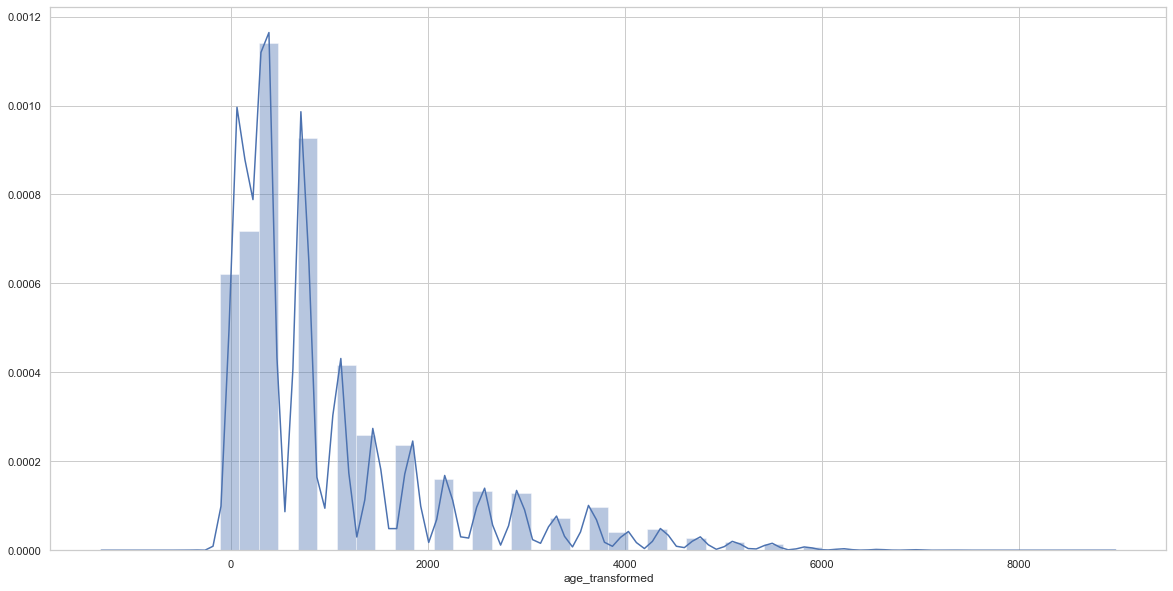

In [229]:
plt.figure(figsize = (20,10))
sns.distplot(dog_df.age_transformed)

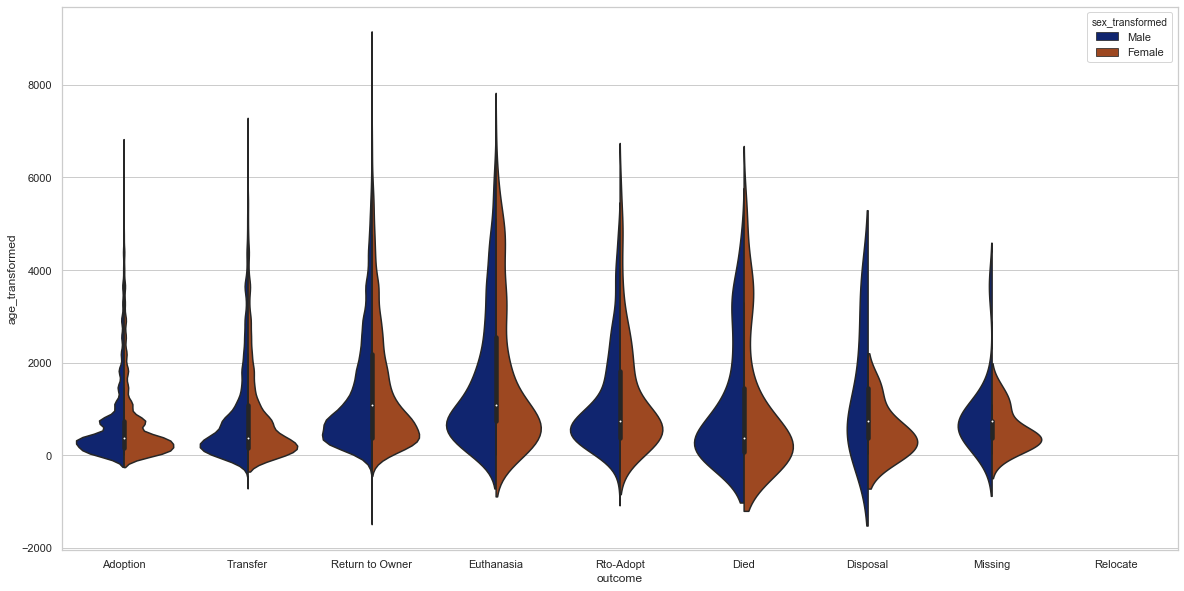

In [236]:
# dog age distribution: 
# adopted vs others
# 
plt.figure(figsize = (20,10))
sns.violinplot(x="outcome", y="age_transformed", hue="sex_transformed",
               data=dog_df, palette="dark", edgecolor=".6",
               order = ['Adoption', 'Transfer', 'Return to Owner', 'Euthanasia','Rto-Adopt', 'Died', 'Disposal', 'Missing', 'Relocate'],
               split=True)

In [239]:
dog_df['encode_outcome'] = dog_df.outcome.apply(lambda x: 'no_adopt' if x!= 'Adoption' else x)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


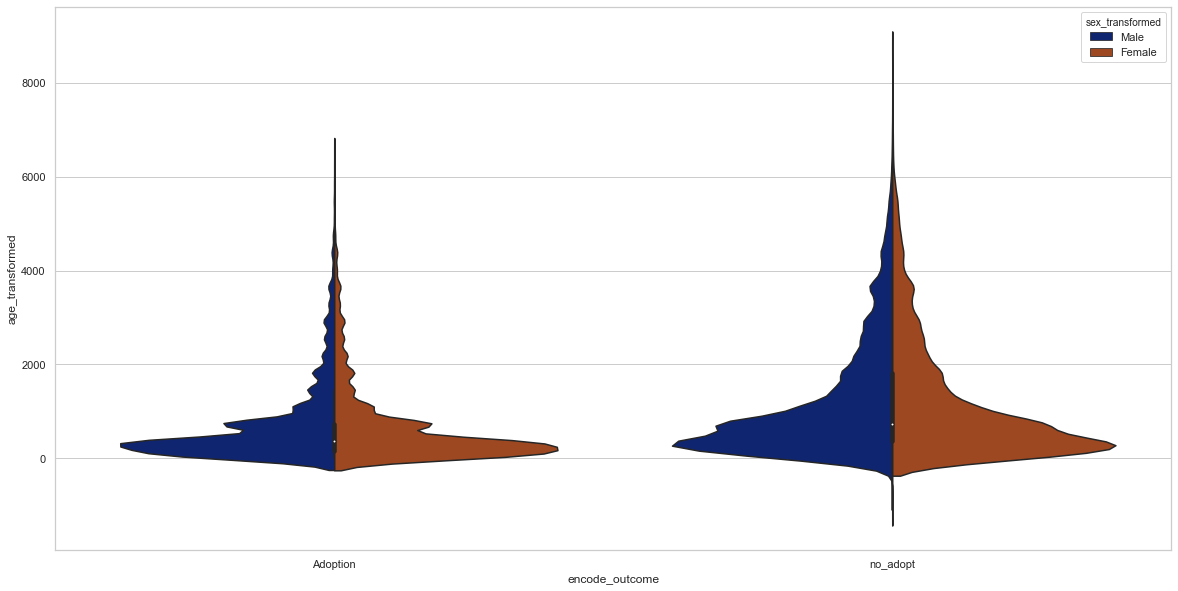

In [244]:
# visually, gender is not as big as a factor in adoption of dogs
plt.figure(figsize = (20,10))
sns.violinplot(x="encode_outcome", y="age_transformed", hue="sex_transformed",
               data=dog_df, palette="dark", edgecolor=".6",
               split=True)

In [247]:
# average age of adopted versus not-adopted dogs

# male
adopted_male_dog = dog_df[(dog_df.encode_outcome == "Adoption") & (dog_df.sex_transformed == "Male")].age_transformed
no_male_dog = dog_df[(dog_df.encode_outcome == "no_adopt") & (dog_df.sex_transformed == "Male")].age_transformed
# female
adopted_female_dog = dog_df[(dog_df.encode_outcome == "Adoption") & (dog_df.sex_transformed == "Female")].age_transformed
no_female_dog = dog_df[(dog_df.encode_outcome == "no_adopt") & (dog_df.sex_transformed == "Female")].age_transformed

In [248]:
print("""
The average age of adopted male dogs is: {:.2f}
The average age of non-adopted male dogs is: {:.2f}
--
The average age of adopted female dogs is: {:.2f}
The average age of non-adopted female dogs is: {:.2f}
"""
      .format(adopted_male_dog.mean(), no_male_dog.mean(), 
              adopted_female_dog.mean(), no_female_dog.mean()))


The average age of adopted male dogs is: 725.57
The average age of non-adopted male dogs is: 1205.22
--
The average age of adopted female dogs is: 695.81
The average age of non-adopted female dogs is: 1195.45



In [249]:
tstat, p = stats.ttest_ind(adopted_male_dog, no_male_dog)
tstatf, pf = stats.ttest_ind(adopted_female_dog, no_female_dog)

In [250]:
print("""
(Comparison of the average age of adopted versus not-adopted male dogs:
Result: {:.2f} with the p-value of {:.2f}
--
Comparison of the average age of adopted versus not-adopted female dogs:
Result: {:.2f} with the p-value of {:.2f})
""".format(tstat, p, tstatf, pf))


(Comparison of the average age of adopted versus not-adopted male dogs:
Result: -41.12 with the p-value of 0.00
--
Comparison of the average age of adopted versus not-adopted female dogs:
Result: -39.12 with the p-value of 0.00)



In [254]:
# age after 1700 days, seems like ratio started to change between adopt/ no-adopt
all_old = len(dog_df[dog_df.age_transformed > 1642])
adopted_old = len(dog_df[(dog_df.age_transformed > 1642) & (dog_df.encode_outcome == "Adoption")])
no_adopt_old = len(dog_df[(dog_df.age_transformed > 1642) & (dog_df.encode_outcome == "no_adopt")])

In [260]:
print("""
Percentage of dogs over 4.5 years old and
adopted: {:.2f}%,
not adopted: {:.2f}%
""".format(100*(adopted_old/all_old), 100*(no_adopt_old/all_old)))


Percentage of dogs over 4.5 years old and
adopted: 29.09%,
not adopted: 70.91%



In [ ]:
# write a funcion to guage the true limiting cutoff for age influencing adtoption

In [269]:
all_old = len(dog_df[dog_df.age_transformed > 2])
adopted_old = len(dog_df[(dog_df.age_transformed > 2) & (dog_df.encode_outcome == "Adoption")])
cal = adopted_old/all_old

In [279]:
age_at_adoption = []
adoption_rate = []
for age in range(1, (int(df.age_transformed.max()+1)), 365):
    all_old = len(dog_df[dog_df.age_transformed > age])
    adopted_old = len(dog_df[(dog_df.age_transformed > age) & (dog_df.encode_outcome == "Adoption")])
    cal = adopted_old/all_old
    age_at_adoption.append(int(age/365))
    adoption_rate.append(round(cal, 2))
    print("Age in year {} and relative adoption rate: {:.2f}%".format(age, cal*100))

    if cal <= 0:
        print("The time when adoption rate begin to go downhill...{:.2f}".format(age/365))
        break
    else:
        continue

Age in year 1 and relative adoption rate: 46.88%
Age in year 366 and relative adoption rate: 36.49%
Age in year 731 and relative adoption rate: 32.15%
Age in year 1096 and relative adoption rate: 30.39%
Age in year 1461 and relative adoption rate: 29.09%
Age in year 1826 and relative adoption rate: 27.30%
Age in year 2191 and relative adoption rate: 26.18%
Age in year 2556 and relative adoption rate: 25.28%
Age in year 2921 and relative adoption rate: 22.51%
Age in year 3286 and relative adoption rate: 20.34%
Age in year 3651 and relative adoption rate: 17.57%
Age in year 4016 and relative adoption rate: 16.09%
Age in year 4381 and relative adoption rate: 11.44%
Age in year 4746 and relative adoption rate: 8.64%
Age in year 5111 and relative adoption rate: 8.81%
Age in year 5476 and relative adoption rate: 5.95%
Age in year 5841 and relative adoption rate: 5.06%
Age in year 6206 and relative adoption rate: 5.00%
Age in year 6571 and relative adoption rate: 0.00%
The time when adoption 

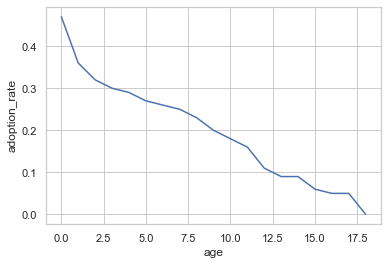

In [280]:
elbow = pd.DataFrame({'age': age_at_adoption, 'adoption_rate': adoption_rate})
sns.lineplot(x="age", y="adoption_rate", data=elbow)

In [86]:
# handle color and breed
print(f"""
peek unique breed: 
{df.breed.unique().tolist()}
-
peek unique colors:
{df.color.unique().tolist()}
""")


peek unique breed: 
['Anatol Shepherd/Labrador Retriever', 'Domestic Shorthair Mix', 'Domestic Medium Hair Mix', 'Opossum', 'Australian Cattle Dog Mix', 'Pit Bull Mix', 'German Shepherd Mix', 'Dogo Argentino Mix', 'Black Mouth Cur Mix', 'Bat', 'Collie Rough Mix', 'American Staffordshire Terrier Mix', 'Dachshund/Chihuahua Shorthair', 'Chihuahua Shorthair Mix', 'Pug Mix', 'Rottweiler/Labrador Retriever', 'Beagle Mix', 'Manx Mix', 'Miniature Schnauzer Mix', 'Pointer Mix', 'American Shorthair Mix', 'Bat Mix', 'Great Dane', 'Redbone Hound Mix', 'Dachshund Mix', 'Chihuahua Longhair Mix', 'Chicken Mix', 'Pit Bull', 'German Shepherd', 'Great Pyrenees/Labrador Retriever', 'Wire Hair Fox Terrier Mix', 'Landseer', 'Norwich Terrier Mix', 'Miniature Pinscher Mix', 'Boxer Mix', 'Catahoula/Pointer', 'English Pointer', 'Siamese Mix', 'Domestic Shorthair', 'Domestic Medium Hair', 'Queensland Heeler/Pointer', 'Weimaraner', 'Miniature Poodle', 'Pit Bull/Chow Chow', 'American Mix', 'Doberman Pinsch Mix',

In [95]:
cat_temp = df[df.species == 'Cat']
cat_temp.color.nunique()

266

In [96]:
dog_temp = df[df.species == 'Dog']
dog_temp.color.nunique()

367

In [16]:
import re

In [17]:
# take care of months
df.age_destiny = df.age_destiny.apply(lambda x: re.sub(r'([^\d+])', '',x) if 'months' in x else x)
df.age_destiny = df.age_destiny.apply(lambda x: re.sub(r'([^\d+])', '',x) if 'month' in x else x)

In [21]:
def name_adopt_relationship(data):
    # get unique names
    name_list = data.Name.dropna().unique()
    # convert ndarray to list for iteration
    name_list = list(name_list)
    # create empty lists to hold calculated data
    name = []
    adopt_rate = []
    count = []
    dict = {}
    for n in name_list:
        # store name into list
        name.append(n)
        # calculate adoption rate for each name 
        # divide by all outcomes attached with that particular name
        rate = len(data[(data.Name == n) & (data["Outcome Type"] == "Adoption")]) / len(data[data.Name == n])
        # store name into rate
        adopt_rate.append(rate)
        count.append(len(data[data.Name == n]))
    dict = {'pet_name': name, 'name_count': count, 'adopt_rate': adopt_rate}
    return pd.DataFrame(dict)

In [22]:
cat = name_adopt_relationship(cat)
cat

,pet_name,name_count,adopt_rate
0,*Donatello,1,1.000000
1,*Zeus,5,1.000000
2,Artemis,15,0.666667
3,Luigi,9,0.444444
4,*Liza,6,0.333333
...,...,...,...
9361,*Bop,1,1.000000
9362,*Mynx,1,1.000000
9363,*Mike D,1,0.000000
9364,*Slicer,1,1.000000


In [28]:
cat[cat.name_count >= 50].sort_values(by = 'adopt_rate', ascending = False)

,pet_name,name_count,adopt_rate
677,Bella,66,0.833333
100,Luna,89,0.820225
312,Charlie,63,0.746032
2293,Oliver,52,0.692308
389,Smokey,56,0.678571
488,Lucy,51,0.666667
705,Shadow,50,0.660000
269,Kitty,58,0.568966


In [26]:
dog_result = name_adopt_relationship(dog)
dog_result

,pet_name,name_count,adopt_rate
0,Moose,34,0.588235
1,Terry,5,0.200000
2,King,143,0.349650
3,Canine,1,0.000000
4,Buster,98,0.377551
...,...,...,...
12927,Jemba,1,0.000000
12928,Kellsie,1,1.000000
12929,Azrael,1,0.000000
12930,*Skip,1,0.000000


In [27]:
dog_result[dog_result.name_count >= 30].sort_values(by = 'adopt_rate', ascending = False)

,pet_name,name_count,adopt_rate
433,*Penny,32,0.750000
805,Cleo,33,0.727273
506,Olive,36,0.722222
92,*Charlie,52,0.711538
1557,Sunny,38,0.684211
...,...,...,...
1013,Fluffy,31,0.193548
1060,Junior,42,0.190476
568,Pancho,34,0.176471
429,Kilo,34,0.088235


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the example car crash dataset
crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="total", y="abbrev", data=crashes,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="alcohol", y="abbrev", data=crashes,
            label="Alcohol-involved", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="",
       xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)

In [40]:
df[df.Name == 'Sasha']["Outcome Type"].value_counts()

Adoption           55
Return to Owner    41
Transfer           13
Euthanasia          4
Missing             1
Rto-Adopt           1
Died                1
Name: Outcome Type, dtype: int64

In [41]:
df[df.Name == 'Rocky']["Outcome Type"].value_counts()

Return to Owner    149
Adoption           114
Transfer            41
Euthanasia          17
Rto-Adopt            6
Missing              1
Disposal             1
Name: Outcome Type, dtype: int64

In [43]:
len(df[(df.Name == 'Rocky') & (df["Outcome Type"] == "Adoption")]) / len(df[df.Name == 'Rocky'])

0.3465045592705167

In [37]:
df.groupby('Name')['Outcome Type'].nunique().sort_values(ascending=False)

Name
Sasha                       7
Rocky                       7
Molly                       6
Coco                        6
Luna                        6
Blue                        6
Lucky                       6
Rex                         6
Shadow                      6
Max                         6
Spot                        6
Mia                         6
Cinnamon                    6
Sparky                      6
Princess                    6
Buddy                       6
Diamond                     6
Puppy                       6
Cash                        6
Tank                        6
Chloe                       6
Sam                         6
King                        6
Bella                       6
Lily                        6
Maddie                      5
Mya                         5
Chester                     5
Chewy                       5
Cali                        5
Lola                        5
Loki                        5
Ralph                       5
Butch

In [13]:
df_19[df_19.DateTime == df_19.MonthYear].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111753 entries, 0 to 111752
Data columns (total 12 columns):
Animal ID           111753 non-null object
Name                76509 non-null object
DateTime            111753 non-null object
MonthYear           111753 non-null object
Date of Birth       111753 non-null object
Outcome Type        111745 non-null object
Outcome Subtype     50875 non-null object
Animal Type         111753 non-null object
Sex upon Outcome    111749 non-null object
Age upon Outcome    111717 non-null object
Breed               111753 non-null object
Color               111753 non-null object
dtypes: object(12)
memory usage: 11.1+ MB


In [17]:
df_19['Animal Type'].value_counts()

Dog          63223
Cat          42230
Other         5767
Bird           516
Livestock       17
Name: Animal Type, dtype: int64

In [7]:
df_19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111753 entries, 0 to 111752
Data columns (total 12 columns):
Animal ID           111753 non-null object
Name                76509 non-null object
DateTime            111753 non-null object
MonthYear           111753 non-null object
Date of Birth       111753 non-null object
Outcome Type        111745 non-null object
Outcome Subtype     50875 non-null object
Animal Type         111753 non-null object
Sex upon Outcome    111749 non-null object
Age upon Outcome    111717 non-null object
Breed               111753 non-null object
Color               111753 non-null object
dtypes: object(12)
memory usage: 10.2+ MB


In [15]:
prepare.report_col_with_null(df_19)

Animal ID
------------------------------------------------------------
Number of nulls in Animal ID is: 0
------------------------------------------------------------
Number of unique items: A721033    33
A718223    14
A718877    12
A706536    11
A716018     9
A717053     9
A705625     8
A738324     8
A738073     8
A670612     8
A754989     8
A694501     8
A616444     8
A733594     8
A761266     8
A693283     8
A763125     7
A737833     7
A665334     7
A662586     7
A701265     7
A774102     7
A667894     7
A761751     7
A770009     7
A593537     7
A742421     7
A658733     7
A737854     7
A683108     7
           ..
A772539     1
A688415     1
A792992     1
A792445     1
A715661     1
A766638     1
A733520     1
A758415     1
A672905     1
A683694     1
A797539     1
A679579     1
A720070     1
A779546     1
A697183     1
A668019     1
A731948     1
A748685     1
A802403     1
A722973     1
A693362     1
A724829     1
A788913     1
A723724     1
A753355     1
A739942     1
A737231    

Outcome Subtype
------------------------------------------------------------
Number of nulls in Outcome Subtype is: 60878
------------------------------------------------------------
Number of unique items: Partner                28011
Foster                  8577
Rabies Risk             3240
SCRP                    3211
Suffering               2998
Snr                     2324
In Kennel                538
Aggressive               526
Offsite                  383
Medical                  300
In Foster                261
At Vet                   179
Behavior                 151
Enroute                   72
Underage                  29
Court/Investigation       23
In Surgery                22
Possible Theft            16
Field                      8
Barn                       4
Prc                        1
Customer S                 1
Name: Outcome Subtype, dtype: int64
------------------------------------------------------------
Animal Type
----------------------------------------------

,0,1,2,3,4
0,Name,Outcome Type,Outcome Subtype,Sex upon Outcome,Age upon Outcome
0,35244,8,60878,4,36


Using real data from Animal Care Services and a Decision Tree Classifier, I was able to predict if an animal would be euthanized or adopted with an accuracy of over 90%. To achieve this result I engineered new features by thinking about what factors contribute to an animal being adopted and also used undersampling to balance the classes. I then used cross-validation and tried several classification models to determine which performed the best.

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: object(10)
memory usage: 2.0+ MB


In [5]:
df.AnimalType.unique()

array(['Dog', 'Cat'], dtype=object)

In [4]:
# ID seems unique
df.AnimalID.nunique()

26729

In [10]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


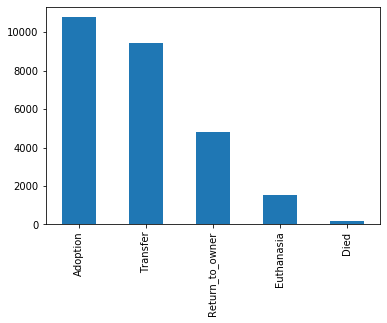

In [20]:
df.OutcomeType.value_counts().plot(kind='bar')

**Initial thought after peek at data**
1. sep animal type
2. animals w/o names might have worse outcome
3. more adoption: neutered/ spayed ones, young, specific breed/ color

A lot of encoding?

In [5]:
# missing a lot of names
# animals without names > worse outcome?
df.Name.isnull().sum()

7691

In [6]:
# this works too lol
check = df.columns[df.isnull().any()]
check

Index(['Name', 'OutcomeSubtype', 'SexuponOutcome', 'AgeuponOutcome'], dtype='object')

In [8]:
null_pd = prepare.report_col_with_null(df)

AnimalID
------------------------------------------------------------
Number of nulls in AnimalID is: 0
------------------------------------------------------------
Number of unique items: A715005    1
A686587    1
A687473    1
A694727    1
A662735    1
A710345    1
A691646    1
A682472    1
A710577    1
A694766    1
A701338    1
A664509    1
A672286    1
A669376    1
A693120    1
A712884    1
A708640    1
A679475    1
A715273    1
A682801    1
A695169    1
A678095    1
A711613    1
A695598    1
A678461    1
A670291    1
A713610    1
A712827    1
A689294    1
A715310    1
          ..
A703926    1
A688067    1
A671669    1
A712941    1
A710843    1
A678697    1
A567323    1
A676218    1
A701522    1
A665172    1
A667150    1
A709694    1
A707783    1
A710864    1
A690459    1
A692787    1
A720498    1
A705933    1
A713155    1
A713021    1
A686141    1
A661592    1
A690173    1
A669397    1
A659414    1
A686364    1
A663901    1
A713778    1
A685120    1
A696291    1
Name: AnimalID, Le

In [9]:
null_pd

,0,1,2,3
0,Name,OutcomeSubtype,SexuponOutcome,AgeuponOutcome
0,7691,13612,1,18


In [35]:
pd.crosstab(df.AnimalType, df.OutcomeType).apply(lambda r: r/r.sum(), axis=1)

OutcomeType,Adoption,Died,Euthanasia,Return_to_owner,Transfer
AnimalType,,,,,
Cat,0.383690,0.013203,0.063769,0.044907,0.494431
Dog,0.416608,0.003206,0.054184,0.274832,0.251170


In [36]:
pd.crosstab(df.OutcomeType, df.AnimalType).apply(lambda r: r/r.sum(), axis=1)

AnimalType,Cat,Dog
OutcomeType,,
Adoption,0.396694,0.603306
Died,0.746193,0.253807
Euthanasia,0.456592,0.543408
Return_to_owner,0.104471,0.895529
Transfer,0.584271,0.415729


In [82]:
df.replace(r'^\s*$', np.nan, regex = True, inplace = True) 

In [ ]:
(df.DateTime.value_counts(sort = False)).plot()